In [2]:
!pip install pymrmr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pymrmr: filename=pymrmr-0.1.11-cp310-cp310-linux_x86_64.whl size=390768 sha256=fd230ddd3ca3e37d4321133b5bfac81d3601e11f85d04af7222efe48fb7a14fc
  Stored in directory: /root/.cache/pip/wheels/46/ae/55/4a2479c5f0de7eb363fe970cb18e4a750e03e4e63b1b5c2005
Successfully built pymrmr


In [4]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, Dropout, MaxPooling1D, Flatten, Dense, LayerNormalization, BatchNormalization, Activation
import os
import random
from  keras.regularizers import l2
from sklearn.preprocessing import PowerTransformer


In [17]:
train = pd.read_csv('/content/train_t5_pssm.csv')
train_esm_650 = pd.read_csv('/content/train_esm650.csv')
train_esm_3B = pd.read_csv('/content/train_esm.csv')


print(train.shape)


# Convert the embedding strings to numpy arrays
X_train_embeddings = train['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))


X_train_PSSM = train['PSSM'].apply(lambda x: np.array([float(i) for i in x.strip("[]").split()]))


X_train_PSSM = np.stack(X_train_PSSM.values)


# Convert to a numpy array if needed
X_train_pt5 = np.stack(X_train_embeddings.values)


# use power transform to normalize the pssm
scaler = PowerTransformer()
X_train_PSSM = scaler.fit_transform(X_train_PSSM)

X_train_esm_650 = train_esm_650['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))


X_train_esm_650 = np.stack(X_train_esm_650.values)


X_train_esm_3B = train_esm_3B['embedding'].apply(lambda x: np.array([float(i) for i in x.strip('[]').split()]))

X_train_esm_3B = np.stack(X_train_esm_3B.values)

# Extract sequences
X_train = train['sequence'].values


# Extract labels
y_train = train['label'].values


# Extract sequences
X_train = train['sequence'].values


# Extract labels
y_train = train['label'].values


# Create a dictionary to map amino acids to integers
amino_acids = 'ACDEFGHIKLMNPQRSTVWY-'
aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

# Convert the sequences to a numerical format and convert to numpy arrays
X_train_num = [[aa_to_int[aa] for aa in seq] for seq in X_train]

X_train_num = np.array(X_train_num)

# Pass the sequences through the embedding layer
X_train_num = np.eye(21)[X_train_num]
#flatten the array
X_train_num = X_train_num.reshape(X_train_num.shape[0], X_train_num.shape[1]*X_train_num.shape[2])


#print shapes
print(X_train_pt5.shape)

print(X_train_esm_650.shape)

print(X_train_esm_3B.shape)

print(X_train_PSSM.shape)

print(X_train_num.shape)

print(y_train.shape)




(8411, 6)
(8411, 1024)
(8411, 1280)
(8411, 2560)
(8411, 20)
(8411, 693)
(8411,)


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Example with one group (word_embedding)
def apply_pca_to_group(X_group, n_components=10):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_group)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca.explained_variance_ratio_

word_embedding_pca, word_embedding_var_ratio = apply_pca_to_group(X_train_num)
print("Word Embedding Explained Variance:", word_embedding_var_ratio)
prot_t5_pca, prot_t5_var_ratio = apply_pca_to_group(X_train_pt5)
print("Prot_t5 Explained Variance:", prot_t5_var_ratio)
esm_650_pca, esm_650_var_ratio = apply_pca_to_group(X_train_esm_650)
print("ESM_650 Explained Variance:", esm_650_var_ratio)
esm_3B_pca, esm_3B_var_ratio = apply_pca_to_group(X_train_esm_3B)
print("ESM_3B Explained Variance:", esm_3B_var_ratio)
pssm_pca, pssm_var_ratio = apply_pca_to_group(X_train_PSSM)
print("PSSM Explained Variance:", pssm_var_ratio)



Word Embedding Explained Variance: [0.01762439 0.01635325 0.00354433 0.00344176 0.00334695 0.00303774
 0.0027774  0.00270296 0.00262217 0.0025964 ]
Prot_t5 Explained Variance: [0.04825255 0.02942512 0.02706921 0.02014168 0.01807625 0.01528529
 0.01364655 0.01240348 0.01173866 0.01119771]
ESM_650 Explained Variance: [0.06721411 0.01911797 0.01506379 0.01214531 0.01150833 0.01074919
 0.00862866 0.00811104 0.00773854 0.00751087]
ESM_3B Explained Variance: [0.05641356 0.0126858  0.00948623 0.00815983 0.00708505 0.00667284
 0.00614061 0.00553349 0.0053167  0.00491223]
PSSM Explained Variance: [0.47052615 0.11999805 0.0768104  0.04755546 0.0406321  0.03425318
 0.0292239  0.02510213 0.02350271 0.02063087]


In [27]:
import pandas as pd
import numpy as np
import pymrmr

# Concatenate all PCA-transformed data and ensure target variable is included
X_train_pca = np.hstack([word_embedding_pca, prot_t5_pca, esm_650_pca, esm_3B_pca, pssm_pca])

# Create a DataFrame from the PCA features and add the target variable
X_train_pca_df = pd.DataFrame(X_train_pca)
X_train_pca_df['target'] = y_train  # Assuming y_train is your target variable

# Reorder the DataFrame to have the target as the first column
X_train_pca_df = X_train_pca_df[['target'] + [col for col in X_train_pca_df.columns if col != 'target']]

# Ensure the target variable is categorical (if applicable)
X_train_pca_df['target'] = X_train_pca_df['target'].astype('category')

#*** Change the column names to strings ***
X_train_pca_df.columns = X_train_pca_df.columns.astype(str)

# Apply mRMR for feature selection (e.g., select top 10 features)
selected_features = pymrmr.mRMR(X_train_pca_df, 'MIQ', 20)  # 'MIQ' for Maximal Information Quotient

# Print the selected features
print("Selected features by mRMR:", selected_features)


Selected features by mRMR: ['11', '7', '46', '6', '4', '17', '14', '12', '9', '19', '41', '13', '16', '2', '49', '15', '5', '26', '0', '21']


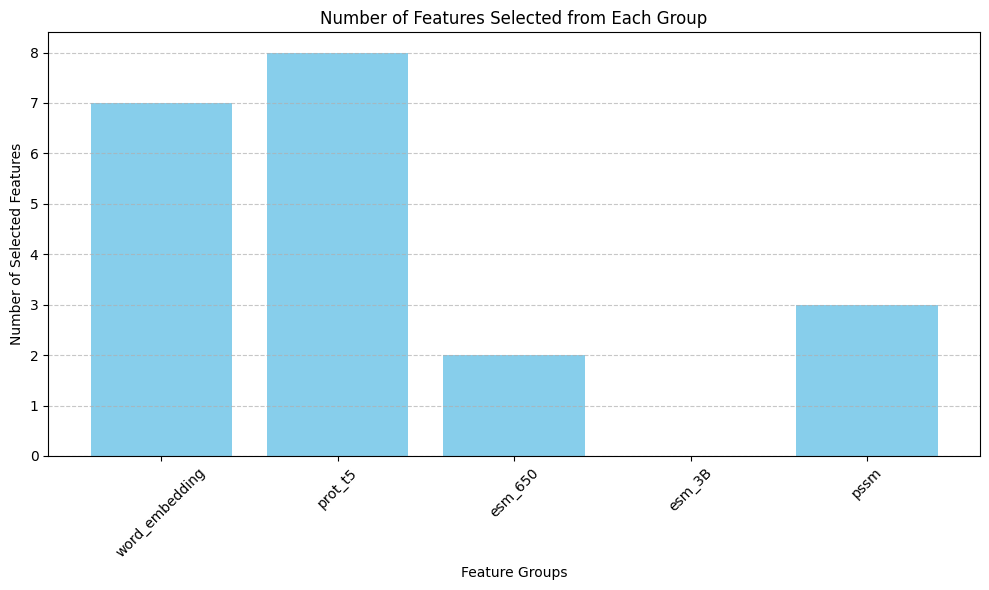

In [30]:
import matplotlib.pyplot as plt

# Count how many features were selected from each group
feature_groups = ['word_embedding', 'prot_t5', 'esm_650', 'esm_3B', 'pssm']
num_features_per_group = {group: 0 for group in feature_groups}

# Loop through the selected features to count them
for feature in selected_features:
    feature = int(feature)
    if feature < 10:
        num_features_per_group['word_embedding'] += 1
    elif feature < 20:
        num_features_per_group['prot_t5'] += 1
    elif feature < 30:
        num_features_per_group['esm_650'] += 1
    elif feature < 40:
        num_features_per_group['esm_3B'] += 1
    elif feature < 50:
        num_features_per_group['pssm'] += 1

# Prepare data for plotting
groups = list(num_features_per_group.keys())
counts = list(num_features_per_group.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(groups, counts, color='skyblue')
plt.xlabel('Feature Groups')
plt.ylabel('Number of Selected Features')
plt.title('Number of Features Selected from Each Group')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
